In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first

In [3]:
import numba
import numba.cuda

numba.config.NUMBA_NUM_THREADS = 8

In [4]:
import tmol.tests.data

In [5]:
import tmol.utility.numba
from tmol.utility.reactive import reactive_attrs, reactive_property

from tmol.tests.benchmark import make_fixture, make_subfixture, stat_frame, subfixture

In [6]:
import tmol.score

In [7]:
import torch

In [8]:
import functools

In [9]:
decoys = tmol.tests.data.structures_bysize()

In [43]:
import tmol.score.ljlk.numba_potential

def benchmark_decoys():
    stats = []
    
    for n, d in decoys.items():
        fixture = make_fixture("lj", stats.append, nres=len(d.tmol_system.residues), natoms=len(d.tmol_coords), model=n)
        
        if fixture.extra_info["nres"] > 600:
            continue
            
        logging.info(f"{n}")
        
        score_graph = tmol.score.CartesianTotalScoreGraph.build_for(d.tmol_system)

        ljlk_resolver = score_graph.param_resolver
        ljlk_atom_types = ljlk_resolver.type_idx(score_graph.atom_types)

        coords = score_graph.coords.detach()[0]
        types = torch.tensor(ljlk_atom_types[0])
        path_length = torch.tensor(score_graph.bonded_path_length[0].astype("u1"))
        
        coords_c = coords.cuda()
        types_c = types.cuda()
        path_length_c = path_length.cuda()

        ljlk_resolver_c = ljlk_resolver.from_database(score_graph.ljlk_database, device=torch.device("cuda"))
        
        @subfixture(fixture)
        def cpu_serial():
            return tmol.score.ljlk.numba_potential.lj_kernel(
                coords,
                types,
                coords,
                types,
                path_length,

                ljlk_resolver.pair_params.lj_sigma,
                ljlk_resolver.pair_params.lj_switch_slope,
                ljlk_resolver.pair_params.lj_switch_intercept,
                ljlk_resolver.pair_params.lj_coeff_sigma12,
                ljlk_resolver.pair_params.lj_coeff_sigma6,
                ljlk_resolver.pair_params.lj_spline_y0,
                ljlk_resolver.pair_params.lj_spline_dy0,

                ljlk_resolver.global_params.lj_switch_dis2sigma,
                ljlk_resolver.global_params.spline_start,
                ljlk_resolver.global_params.max_dis,
                parallel=False,
            ).sum()
            
        @subfixture(fixture)
        def cpu_parallel():
            return tmol.score.ljlk.numba_potential.lj_kernel(
                coords,
                types,
                coords,
                types,
                path_length,

                ljlk_resolver.pair_params.lj_sigma,
                ljlk_resolver.pair_params.lj_switch_slope,
                ljlk_resolver.pair_params.lj_switch_intercept,
                ljlk_resolver.pair_params.lj_coeff_sigma12,
                ljlk_resolver.pair_params.lj_coeff_sigma6,
                ljlk_resolver.pair_params.lj_spline_y0,
                ljlk_resolver.pair_params.lj_spline_dy0,

                ljlk_resolver.global_params.lj_switch_dis2sigma,
                ljlk_resolver.global_params.spline_start,
                ljlk_resolver.global_params.max_dis,
            ).sum()
            
        @subfixture(fixture)
        def cuda():
            try:
                return tmol.score.ljlk.numba_potential.lj_kernel(
                    coords_c,
                    types_c,
                    coords_c,
                    types_c,
                    path_length_c,

                    ljlk_resolver_c.pair_params.lj_sigma,
                    ljlk_resolver_c.pair_params.lj_switch_slope,
                    ljlk_resolver_c.pair_params.lj_switch_intercept,
                    ljlk_resolver_c.pair_params.lj_coeff_sigma12,
                    ljlk_resolver_c.pair_params.lj_coeff_sigma6,
                    ljlk_resolver_c.pair_params.lj_spline_y0,
                    ljlk_resolver_c.pair_params.lj_spline_dy0,

                    ljlk_resolver_c.global_params.lj_switch_dis2sigma,
                    ljlk_resolver_c.global_params.spline_start,
                    ljlk_resolver_c.global_params.max_dis,
                ).sum()
            finally:
                torch.cuda.synchronize()
            
        logging.info(f"cpu_serial: {cpu_serial} cpu_parallel: {cpu_parallel} cuda: {cuda}")
        
    return stats

In [44]:
import importlib
importlib.reload(tmol.score.ljlk.numba_potential)

res = benchmark_decoys()

INFO:root:BYSIZE_400_RES_6AZU
INFO:root:cpu_serial: -169.01104736328125 cpu_parallel: -169.01104736328125 cuda: -169.0109100341797
INFO:root:BYSIZE_200_RES_5MM8
INFO:root:cpu_serial: -18.48027229309082 cpu_parallel: -18.48027229309082 cuda: -18.48025894165039
INFO:root:BYSIZE_250_RES_5N5G
INFO:root:cpu_serial: -308.2018127441406 cpu_parallel: -308.2018127441406 cuda: -308.20184326171875
INFO:root:BYSIZE_300_RES_6F8B
INFO:root:cpu_serial: -429.6112365722656 cpu_parallel: -429.6112365722656 cuda: -429.6112365722656
INFO:root:BYSIZE_100_RES_5UMR
INFO:root:cpu_serial: -156.03292846679688 cpu_parallel: -156.03292846679688 cuda: -156.0329132080078
INFO:root:BYSIZE_055_RES_2JWU
INFO:root:cpu_serial: -31.327796936035156 cpu_parallel: -31.327796936035156 cuda: -31.327789306640625
INFO:root:BYSIZE_500_RES_5V2D
INFO:root:cpu_serial: -422.6450500488281 cpu_parallel: -422.6450500488281 cuda: -422.6450500488281
INFO:root:BYSIZE_040_RES_5UOI
INFO:root:cpu_serial: -104.83419799804688 cpu_parallel: -10

In [18]:
import pandas
import seaborn
from matplotlib import pyplot

In [19]:
dat = stat_frame(res)

dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'lj.cpu_serial'").groupby("nres").time.mean().rename("serial_cpu_mean").to_frame(),
            left_on="nres",
            right_index=True
        ).eval("time / serial_cpu_mean").rename("serial_cpu_relative")
    ),
    axis=1
)

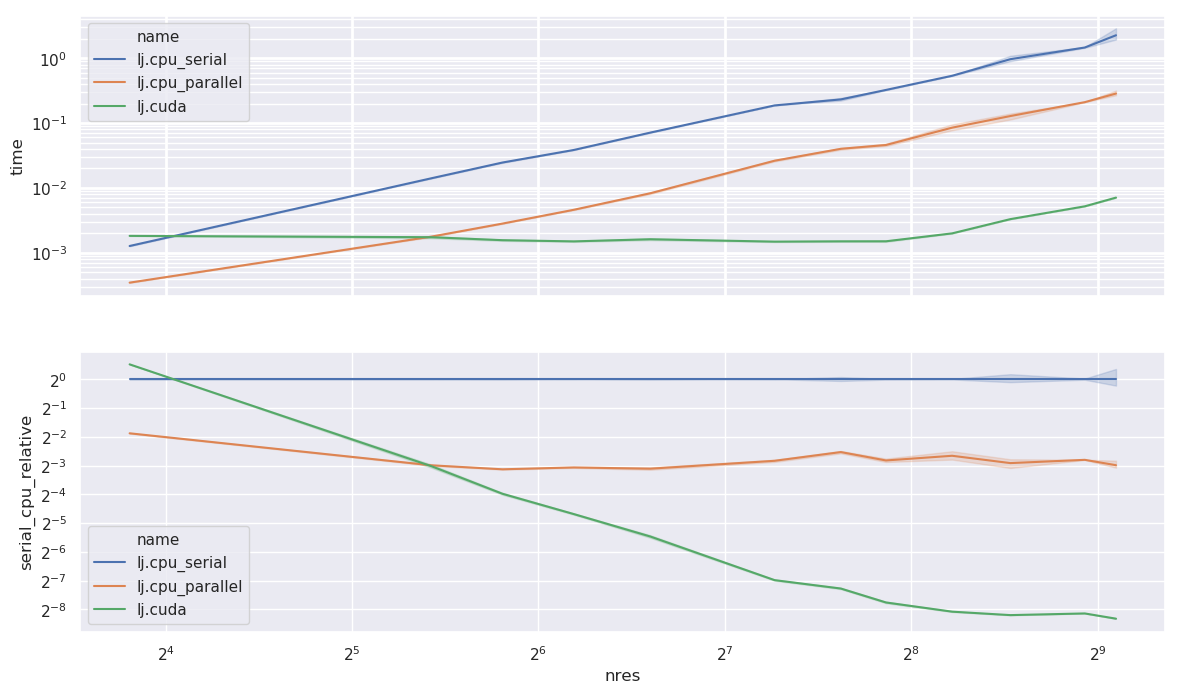

In [37]:
f, (a1, a2) = pyplot.subplots(2, sharex=True)

pyplot.xscale("log", basex=2)

pyplot.sca(a1)
pyplot.yscale("log", basey=10)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("nres", "time", data=dat, hue="name", markers='o')

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
seaborn.lineplot("nres", "serial_cpu_relative", data=dat, hue="name", markers="o")